### There's some weirdness with the reported max values in the FE model

### Status:
Have way to calculate entropy, throughout the session, the two track very well

One thought: it doesn't look like probabilities coming from the softmax corresponding to the probability of choosing card w feature on it..

Softmax estimates are much lower, for ex. max prob of a feature is ~0.14, though prob of choosing feature when max val is high is ~0.9

session: 20180712

In [81]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d

warnings.filterwarnings('ignore')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
session = 20181010
num_bins = 10
behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
beh = pd.read_csv(behavior_path)

# filter trials 
valid_beh = behavioral_utils.get_valid_trials(beh)
feature_selections = behavioral_utils.get_selection_features(valid_beh)
valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
beh = behavioral_utils.get_relative_block_position(beh, num_bins)
beh = behavioral_utils.get_max_feature_value(beh, num_bins)
# fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"

In [83]:
block_switches = beh[beh.TrialAfterRuleChange == 0].TrialNumber.values - 0.5

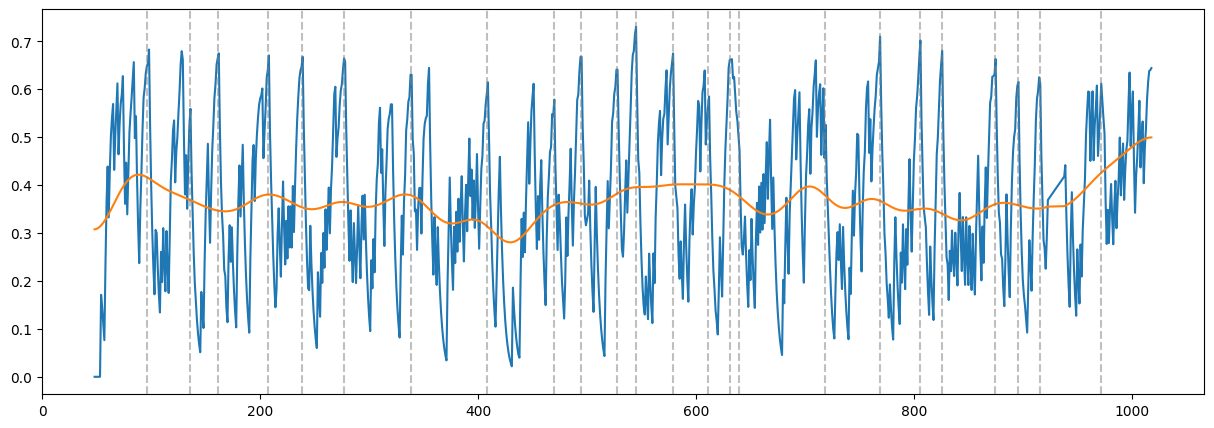

In [84]:
smoothed_val = gaussian_filter1d(beh.MaxValue.values, 20)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(beh.TrialNumber, beh.MaxValue)
ax.plot(beh.TrialNumber, smoothed_val)
for block_switch in block_switches[1:]:
    ax.axvline(block_switch, alpha=0.5, color='gray', linestyle='dashed')

### Look into probabilities calculation with softmax

In [56]:
beh

,index,TrialNumber,BlockNumber,TrialAfterRuleChange,TaskInterrupt,ConditionNumber,Response,ItemChosen,TrialType,CurrentRule,...,POLKADOTValue,RIPPLEValue,SWIRLValue,MaxFeat,BlockLength,TrialInBlock,BlockPosition,BlockPositionBin,MaxValue,MaxValueBin
0,0,48,2,0,NaN,3631,Incorrect,1.0,6,YELLOW,...,0.000000,0.000000,0.000000,SWIRL,49,0,0.000000,0,0.000000,0
1,1,49,2,1,NaN,3510,Incorrect,1.0,6,YELLOW,...,0.000000,0.000000,0.000000,SWIRL,49,1,0.020408,0,0.000000,0
2,2,50,2,2,NaN,3774,Incorrect,2.0,6,YELLOW,...,0.000000,0.000000,0.000000,SWIRL,49,2,0.040816,0,0.000000,0
3,3,51,2,3,NaN,3933,Incorrect,3.0,6,YELLOW,...,0.000000,0.000000,0.000000,SWIRL,49,3,0.061224,0,0.000000,0
4,4,52,2,4,NaN,3823,Incorrect,1.0,6,YELLOW,...,0.000000,0.000000,0.000000,SWIRL,49,4,0.081633,0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952,952,1014,26,42,NaN,5977,Correct,0.0,2,ESCHER,...,-0.022315,-0.041492,-0.079375,ESCHER,47,42,0.893617,8,0.578314,7
953,953,1015,26,43,NaN,6297,Correct,0.0,2,ESCHER,...,-0.020964,-0.038981,-0.074571,ESCHER,47,43,0.914894,9,0.614660,8
954,954,1016,26,44,NaN,5940,Correct,0.0,2,ESCHER,...,-0.019695,-0.036622,-0.070058,ESCHER,47,44,0.936170,9,0.638285,8
955,955,1017,26,45,NaN,5778,Correct,0.0,2,ESCHER,...,-0.018503,-0.034405,-0.065818,ESCHER,47,45,0.957447,9,0.640027,8


In [57]:
logits = np.empty((len(FEATURES), len(beh)))
for i, feat in enumerate(FEATURES):
    logits[i, :] = np.exp(beh[f"{feat}Value"])
# probs = logits / np.sum(logits, axis=0)
# print(probs.shape)
# for i, feat in enumerate(FEATURES):
#     beh[f"{feat}Prob"] = probs[i, :]

In [62]:
sums = np.sum(logits, axis=0)

In [66]:
probs = logits / sums


In [72]:
for i, feat in enumerate(FEATURES):
    beh[f"{feat}Prob"] = probs[i, :]

(12, 957)


In [75]:
for f in FEATURES:
    print(beh[f"{f}Prob"].max())

0.1413643032194024
0.14141682130755207
0.14102016241564166
0.11246946589796807
0.13543016841179917
0.10130572939273043
0.13727846373243488
0.1425398630492711
0.1469639161515743
0.1423103917364371
0.1396477264814563
0.14362863471815707


### Look at entropy

In [85]:
beh = behavioral_utils.calc_feature_probs(beh)
beh = behavioral_utils.calc_feature_value_entropy(beh)

(12, 957)


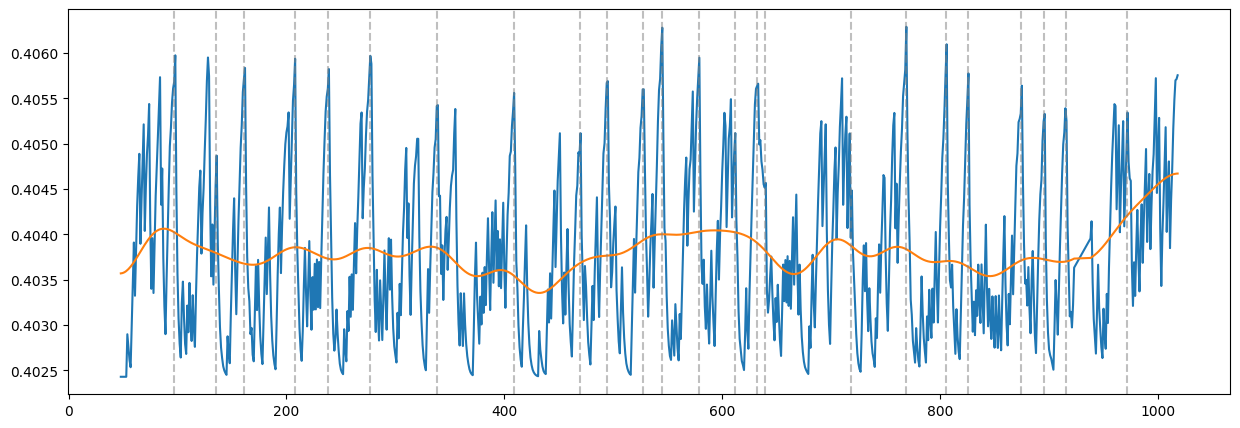

In [88]:
# smoothed_val = gaussian_filter1d(beh.MaxValue.values, 2)
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(beh.TrialNumber, 1 / beh.FeatEntropy)
smoothed_val = gaussian_filter1d(1 / beh.FeatEntropy.values, 20)
ax.plot(beh.TrialNumber, smoothed_val)
for block_switch in block_switches[1:]:
    ax.axvline(block_switch, alpha=0.5, color='gray', linestyle='dashed')

### How correlated is entropy to max value?

Text(0.5, 1.0, 'Cor with r: -0.976, p: 0.000E+00')

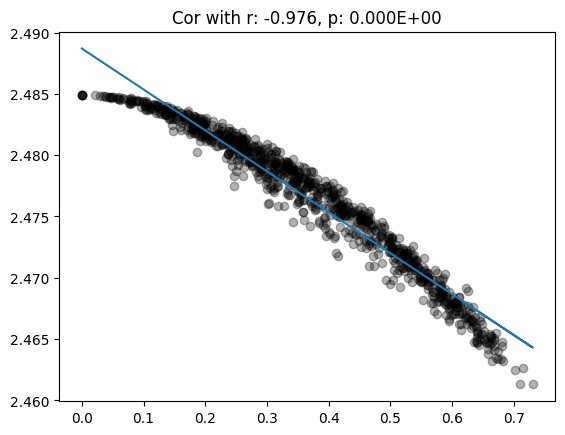

In [89]:
fig, ax = plt.subplots()
slope, intercept, r_value, p_value, std_err = visualization_utils.plot_and_calc_correlation(beh["MaxValue"], beh["FeatEntropy"], ax)
ax.set_title(f"Cor with r: {r_value:.3f}, p: {p_value:.3E}")

